In [ ]:
import nbimporter
from lr_rfr_streampredictions import *

import os
import torch
from torch.optim import SGD
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_rows', 1000)

In [ ]:
three_week_data = pd.read_csv('../csv_files/three_week_data.csv')

In [ ]:
data = three_week_data
print(data.columns)
data

In [ ]:
song = data[data['title'] == 'Listen To The Music']
song = song.sort_values('date', ascending=True)
song['date'] = pd.to_datetime(song['date'])
song = song[['date', 'this_day']]
song

In [ ]:
plt.plot(song['date'], song['this_day'])

In [ ]:
days = ['day_' + str(i) for i in range(21)]
data = data[data['end_of_week'] == True]
data = data.rename(columns={'target': 'Next Full Week Streams'})
data = data[days + ['popularity', 'days_since_release', 'Next Full Week Streams']]
print(data.shape, '\n')
print(data.isnull().sum())

In [ ]:
(data == 0).sum()

In [ ]:
data['days_since_release'] = data['days_since_release'] + 1
data

In [ ]:
train_valid, test = train_test_split(data, test_size = 0.20, random_state = 42)
train, valid = train_test_split(train_valid, test_size = 0.20, random_state = 42)

In [ ]:
def log_apply(data, cols, prediction_col):
    copy = data.copy()
    for col in cols:
        copy[col] = np.log(copy[col])
        copy = copy.rename(columns={col: "log " + col})
    return copy[[c for c in copy if c != ('log ' + prediction_col)] + ['log ' + prediction_col]]

def pipeline(data):
    data = data.pipe(interpolate_vals, days)
    data = data.pipe(log_apply, days + ['days_since_release', 'Next Full Week Streams'], prediction_col='Next Full Week Streams')
    return data.drop('log Next Full Week Streams', axis=1), data['log Next Full Week Streams']

X_train, Y_train = pipeline(train)
X_valid, Y_valid = pipeline(valid)
X_test, Y_test = pipeline(test)

In [ ]:
X_train

In [11]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

lr_pipe = Pipeline([
     ("scaler", scaler), 
     ("pca", pca), 
     ("regressor", Lasso())
])

# Parameters of pipelines can be set using '__' separated parameter names:
lr_params = {
    "pca__n_components": [5, 10, 15, 20, 23],
    "regressor": [Ridge(), Lasso()],
    "regressor__fit_intercept": [True, False],
    "regressor__alpha": [0.1, 0.2, 0.3]
}

search = GridSearchCV(lr_pipe, lr_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
search.fit(X_train, Y_train)

joblib.dump(search, '../models/three_week_preds.joblib')

['../models/three_week_preds.joblib']

In [12]:
saved_search = joblib.load('../models/three_week_preds.joblib')

In [15]:
print("Best parameter (CV score=%0.3e):" % saved_search.best_score_)
print(saved_search.best_params_)

model = saved_search.best_estimator_

Y_train_log_pred = model.predict(X_train)
Y_valid_log_pred = model.predict(X_valid)


Best parameter (CV score=-9.239e-02):
{'pca__n_components': 23, 'regressor': Ridge(alpha=0.3), 'regressor__alpha': 0.3, 'regressor__fit_intercept': True}


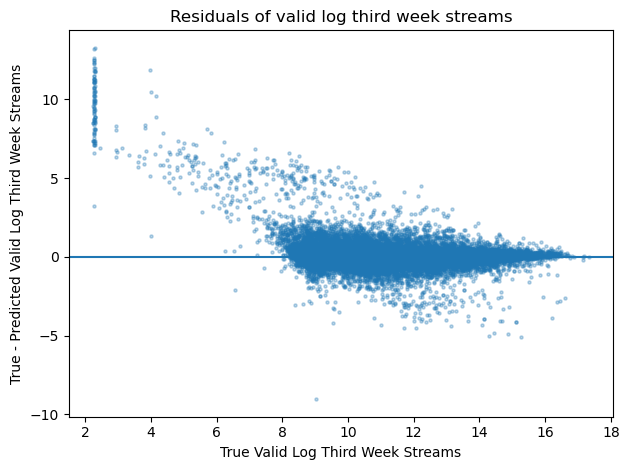

In [16]:
plt.scatter(Y_valid_log_pred, Y_valid - Y_valid_log_pred, alpha=0.3, s=5)
plt.axhline(0)
plt.xlabel("True Valid Log Third Week Streams")
plt.ylabel("True - Predicted Valid Log Third Week Streams")
plt.title("Residuals of valid log third week streams")
plt.tight_layout()

In [18]:
test_filled = interpolate_vals(test, days)

# Compute the number of weekly streams (with no overlap) across the lagged 21 day period
window1 = sum([test_filled[day] for day in days[:7]]) 
window2 = sum([test_filled[day] for day in days[7:14]]) 
window3 = sum([test_filled[day] for day in days[14:]]) 

test_filled

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_14,day_15,day_16,day_17,day_18,day_19,day_20,popularity,days_since_release,Next Full Week Streams
3511817,4585.0,4436.0,4461.0,4337.0,3648.0,4242.0,4493.0,4295.0,4118.0,3190.0,...,4111.0,3833.0,2909.0,3817.0,3603.0,3603.0,3603.0,34.000000,2005,31097
5321229,9925.0,10272.0,10039.0,10383.0,8380.0,8558.0,10252.0,10780.0,10829.0,11199.0,...,11243.0,10449.0,10610.0,10332.0,8701.0,8659.0,10518.0,30.000000,882,69438
7528330,278639.0,272935.0,265924.0,262248.0,256909.0,300234.0,306377.0,282966.0,278876.0,272979.0,...,294571.0,283594.0,281679.0,269768.0,253427.0,288380.0,300424.0,27.347117,1730,1908230
11082708,9760.0,10045.0,10168.0,9572.0,8177.0,8857.0,10133.0,10485.0,10661.0,10217.0,...,9669.0,9884.0,10019.0,10365.0,8474.0,8893.0,9967.0,46.000000,812,69643
14389939,38875.0,36439.0,37830.0,36551.0,29966.0,35475.0,39973.0,37991.0,37792.0,38780.0,...,41098.0,39525.0,37517.0,36990.0,31372.0,38052.0,43977.0,37.000000,190,196222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325300,16744.0,16488.0,15688.0,16226.0,13887.0,14381.0,16339.0,17018.0,17074.0,17352.0,...,16850.0,16338.0,16771.0,15695.0,14009.0,15222.0,15101.0,54.000000,315,95737
12042900,10318.0,9740.0,9500.0,8297.0,7025.0,8616.0,9429.0,10403.0,10488.0,9992.0,...,10528.0,10219.0,10338.0,9840.0,8110.0,9647.0,10622.0,48.000000,707,73052
4724283,2179.0,2703.0,2708.0,2502.0,2004.0,2224.0,2494.0,2269.0,2250.0,2301.0,...,2302.0,2321.0,2366.0,2433.0,2048.0,2072.0,2234.0,8.000000,1863,17348
9666303,11060.0,11263.0,11591.0,11384.0,9216.0,10093.0,11347.0,12332.0,12194.0,12067.0,...,12975.0,11901.0,11267.0,11170.0,9164.0,9113.0,8527.0,27.347117,92,66037


In [25]:
pd.options.display.float_format = '{:.2f}'.format

Y_test_log_pred = model.predict(X_test)
test_filled = interpolate_vals(test, days)

# Compute the number of weekly streams (with no overlap) across the lagged 21 day period
window1 = sum([test_filled[day] for day in days[:7]]) 
window2 = sum([test_filled[day] for day in days[7:14]]) 
window3 = sum([test_filled[day] for day in days[14:]]) 

# Average the three weeks
naive = (window1 + window3 + window3) / 3




results = pd.DataFrame({
    'Y_test': np.e**Y_test,
    'Y_test_pred': np.e**Y_test_log_pred,
    'naive': naive
})

results

,Y_test,Y_test_pred,naive
3511817,31097.00,30608.04,27053.33
5321229,69438.00,65274.22,69611.00
7528330,1908230.00,1629556.77,1962317.33
11082708,69643.00,65217.96,67084.67
14389939,196222.00,229491.55,264057.00
...,...,...,...
12325300,95737.00,110796.25,109908.33
12042900,73052.00,65750.26,67177.67
4724283,17348.00,15410.61,16122.00
9666303,66037.00,73586.47,74729.33


In [26]:
train_rmse = np.sqrt(mean_squared_error(np.e**Y_train, np.e**Y_train_log_pred))
test_rmse = np.sqrt(mean_squared_error(np.e**Y_test, np.e**Y_test_log_pred))
naive_rmse = np.sqrt(mean_squared_error(np.e**Y_test, naive))

print(f"Third Week Model Test Prediction: {test_rmse:0.3e}")
print(f"Third Week Naive Test Prediction: {naive_rmse:0.3e}")

Third Week Model Test Prediction: 1.615e+05
Third Week Naive Test Prediction: 2.733e+05
